In [1]:
import csv
import pandas
from pandas import Series, DataFrame
import pandas as pd
import sqlite3
import matplotlib
%matplotlib inline
matplotlib.pyplot.plot
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 12
import geopandas
from shapely.geometry import Polygon, Point
import numpy as np
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify
import sys
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

In [2]:
file = open('bycounty.csv', encoding='utf-8')
file_reader = csv.reader(file)
data = list(file_reader)
header = data[0]
table = data[1:]

In [3]:
def qry(sql):
    return pd.read_sql(sql,conn)

In [4]:
county = DataFrame(table, columns= header)
county

,OBJECTID,GEOID,GEO,NAME,POSITIVE,NEGATIVE,DEATHS,LoadDttm,POP,ShapeSTArea,ShapeSTLength
0,36,55001,County,Adams,4,120,1,2020-04-23T06:00:00.000Z,20073,3438449806.70312,287039.236701814
1,11,55003,County,Ashland,2,86,0,2020-04-23T06:00:00.000Z,15712,5727268628.4375,770460.66048926
2,40,55005,County,Barron,6,634,0,2020-04-23T06:00:00.000Z,45252,4677777581.72266,273518.663059626
3,21,55007,County,Bayfield,3,118,1,2020-04-23T06:00:00.000Z,14992,8273016941.5625,516531.049687877
4,53,55009,County,Brown,455,1499,2,2020-04-23T06:00:00.000Z,259786,2721387258.97266,331857.050826981
...,...,...,...,...,...,...,...,...,...,...,...
67,68,55133,County,Waukesha,280,2944,14,2020-04-23T06:00:00.000Z,398879,2814107356.61719,212117.252527239
68,16,55135,County,Waupaca,6,289,1,2020-04-23T06:00:00.000Z,51444,3892220630.02734,273669.552662916
69,13,55137,County,Waushara,2,111,0,2020-04-23T06:00:00.000Z,24116,3203281170.625,239611.363862821
70,56,55139,County,Winnebago,46,920,1,2020-04-23T06:00:00.000Z,169926,2903345538.52734,215715.561516527


In [5]:
conn = sqlite3.connect('county')
county.to_sql("county", conn, if_exists="replace", index=False)

In [6]:
data_pd = qry('''
SELECT NAME as name, CAST(POSITIVE AS FLOAT) as positive, CAST(NEGATIVE AS FLOAT) as negative, CAST(DEATHS AS FLOAT) as deaths, 
    (positive + negative) as 'total tests'
FROM county
ORDER BY (positive) DESC
''')

In [7]:
file = open('countypopulation.csv', encoding='utf-8')
file_reader = csv.reader(file)
data = list(file_reader)
header = data[0]
table = data[1:]
pop = DataFrame(table, columns= header)
pop
conn = sqlite3.connect('pop')
pop.to_sql("pop", conn, if_exists="replace", index=False)
pop

,CTYNAME,Pop,GrowthRate
0,Milwaukee County,948201,-0.0105
1,Dane County,542364,10.8675
2,Waukesha County,403072,3.3465
3,Brown County,263378,5.9939
4,Racine County,196584,0.6034
...,...,...,...
67,Forest County,8991,-3.281
68,Pepin County,7289,-2.4491
69,Iron County,5676,-4.1864
70,Menominee County,4658,9.1122


In [8]:
data_pd["percent positive"] = data_pd["positive"]/data_pd["total tests"]*100
data_pd["percent deaths"] = data_pd["deaths"]/(data_pd["positive"]+1)*100

In [9]:
top = data_pd[:20]


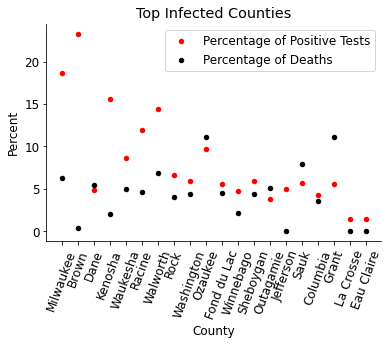

In [10]:
ax = top.plot(x = 'name', y = 'percent positive', kind = 'scatter', color='red', label = "Percentage of Positive Tests")
top.plot(x = 'name', y = 'percent deaths', kind = 'scatter', ax=ax, color = 'black', label="Percentage of Deaths")
plt.xticks(rotation = 70)
plt.ylabel("Percent")
plt.xlabel("County")
plt.title("Top Infected Counties")
plt.legend(loc=1)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [11]:
population = {}
for j in range(len(pop)):
    name = pop["CTYNAME"][j].split()[:-1]
    town = " ".join(name)
    population[town] = pop["Pop"][j]
pop

,CTYNAME,Pop,GrowthRate
0,Milwaukee County,948201,-0.0105
1,Dane County,542364,10.8675
2,Waukesha County,403072,3.3465
3,Brown County,263378,5.9939
4,Racine County,196584,0.6034
...,...,...,...
67,Forest County,8991,-3.281
68,Pepin County,7289,-2.4491
69,Iron County,5676,-4.1864
70,Menominee County,4658,9.1122


In [12]:
numbers = []
missing = []
for i in range(len(data_pd)):
    for j in range(len(pop)):
        name = pop["CTYNAME"][j].split()[:-1]
        town = " ".join(name)
        if town == data_pd["name"][i]:
            numbers.append(int(pop["Pop"][j]))
            missing.append(town) 

In [13]:
counties = geopandas.read_file("county_bound")
nursing = geopandas.read_file("nursing_homes")

In [14]:
geo = {}
for i in range(len(counties)):
    if counties["NAME"][i] in geo:
        continue
    if counties["NAME"][i] not in geo:
        geo[counties["NAME"][i]] = counties["geometry"][i]


In [15]:
this = []
for j in range(len(data_pd)):
    for i in geo:
        if data_pd["name"][j] == i:
            this.append(geo[i])

In [16]:
data_pd["geometry"] = this
data_pd["population"] = numbers
data_pd["percent pop pos"] = data_pd["positive"]/data_pd["population"]*100
data_pd["percent pop tested"] = data_pd["total tests"]/data_pd["population"]*100
data_pd

,name,positive,negative,deaths,total tests,percent positive,percent deaths,geometry,population,percent pop pos,percent pop tested
0,Milwaukee,2382.0,10359.0,150.0,12741,18.695550,6.294587,"(POLYGON ((-88.0038199976383 43.1925890525759,...",948201,0.251213,1.343702
1,Brown,455.0,1499.0,2.0,1954,23.285568,0.438596,"(POLYGON ((-88.2501192432117 44.6797822777909,...",263378,0.172756,0.741899
2,Dane,387.0,7581.0,21.0,7968,4.856928,5.412371,"POLYGON ((-89.0091453050261 43.2848380086325, ...",542364,0.071354,1.469124
3,Kenosha,294.0,1588.0,6.0,1882,15.621679,2.033898,(POLYGON ((-88.08397896563579 42.6699139619877...,169290,0.173666,1.111702
4,Waukesha,280.0,2944.0,14.0,3224,8.684864,4.982206,"POLYGON ((-88.4179931201656 43.1947050295068, ...",403072,0.069466,0.799857
...,...,...,...,...,...,...,...,...,...,...,...
67,Langlade,0.0,78.0,0.0,78,0.000000,0.000000,"POLYGON ((-89.046496579905 45.4644473488926, -...",19268,0.000000,0.404816
68,Lincoln,0.0,147.0,0.0,147,0.000000,0.000000,"POLYGON ((-89.42483069372349 45.4671743249934,...",27689,0.000000,0.530897
69,Pepin,0.0,96.0,0.0,96,0.000000,0.000000,"POLYGON ((-91.6503682463528 44.6836410605132, ...",7289,0.000000,1.317053
70,Taylor,0.0,79.0,0.0,79,0.000000,0.000000,"POLYGON ((-90.04227986736051 45.3818742718075,...",20412,0.000000,0.387027


In [17]:
data_pd.to_csv("county_data")

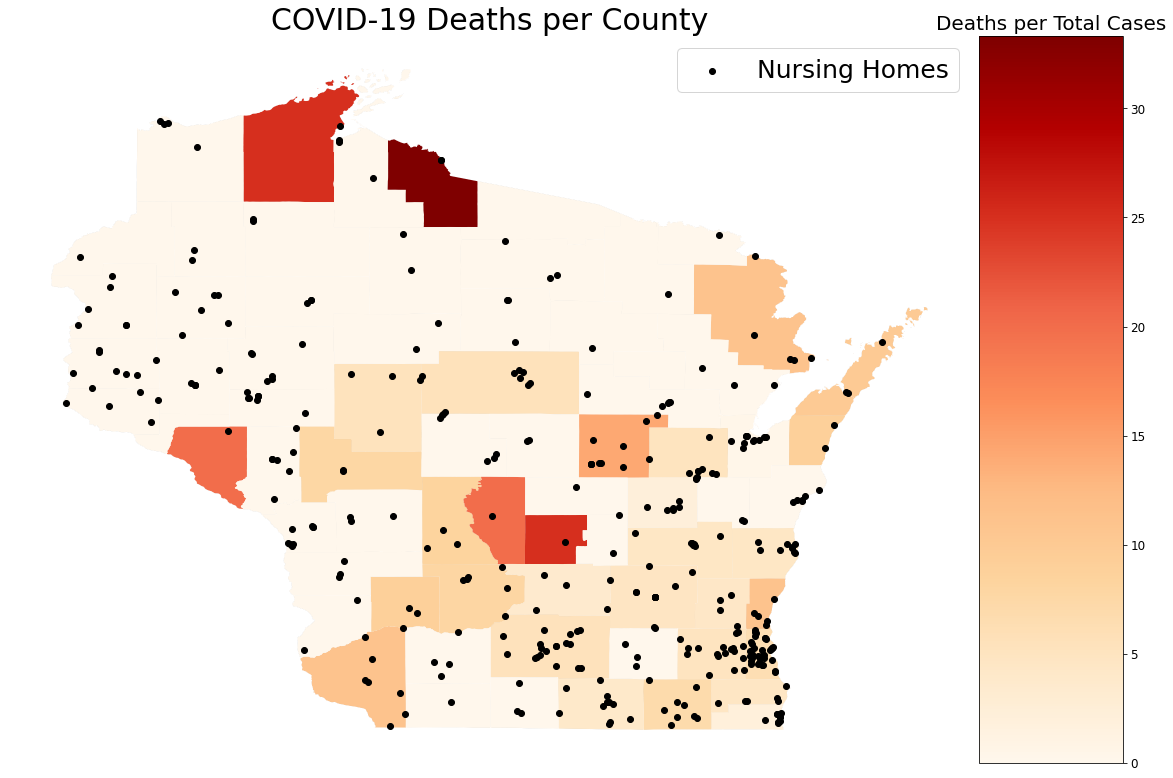

In [18]:
must = geopandas.GeoDataFrame(data_pd, geometry="geometry")
ax = counties.plot(color="grey", figsize=(20,20), edgecolor= "white")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%", pad=0.1)
must.plot(column="percent deaths", cmap="OrRd",figsize=(15,15), legend=True,ax=ax, cax=cax)
nursing.plot(color="black", ax=ax, label = "Nursing Homes")
ax.legend(fontsize = 25)
ax.set_title("COVID-19 Deaths per County", fontsize = 30)
cax.set_title("Deaths per Total Cases", fontsize = 20)
ax.set_axis_off()

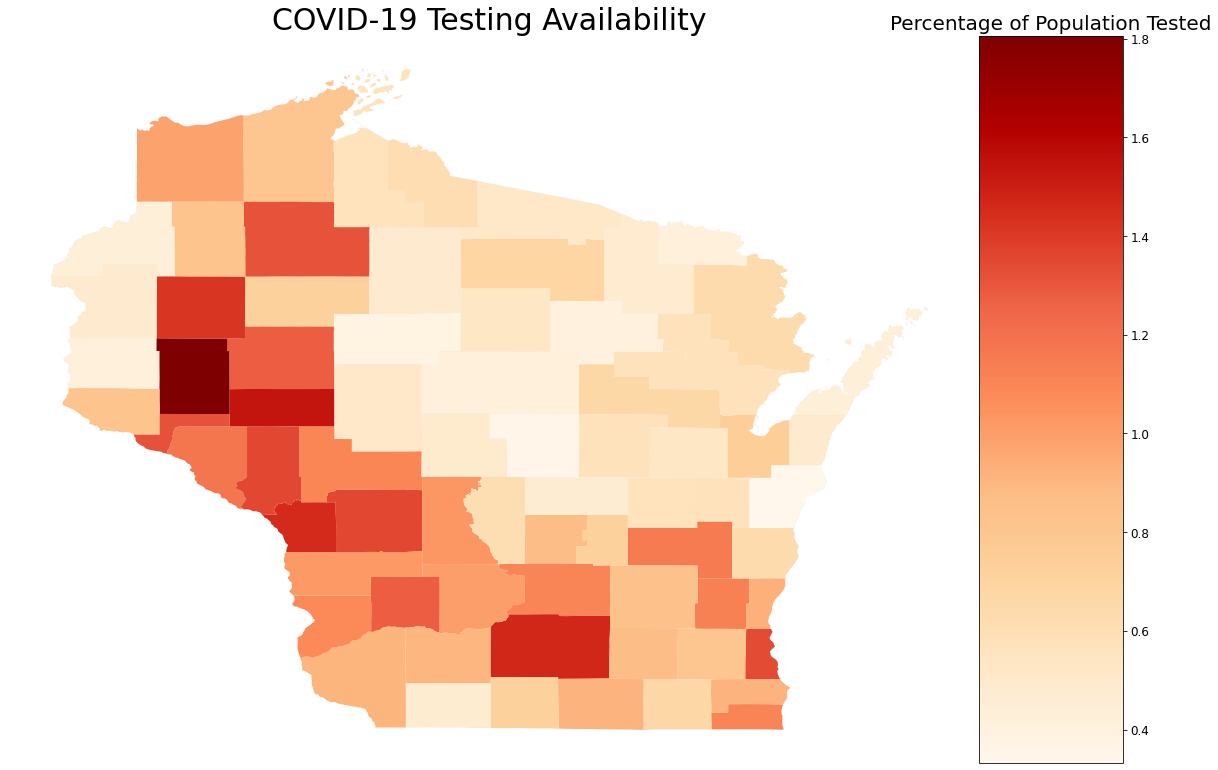

In [19]:
ax = counties.plot(color="grey", figsize=(20,20), edgecolor= "white")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%", pad=0.1)
must.plot(column="percent pop tested", cmap="OrRd",figsize=(15,15), legend=True,ax=ax, cax=cax)
#must.plot(column="percent positive", cmap="Greys",figsize=(15,15), legend=True,ax=ax, cax=cax)
#ax.legend(fontsize = 25)
ax.set_title("COVID-19 Testing Availability", fontsize = 30)
cax.set_title("Percentage of Population Tested", fontsize = 20)
ax.set_axis_off()

In [20]:
file = open('historic.csv', encoding='utf-8')
file_reader = csv.reader(file)
data = list(file_reader)
header = data[0]
table = data[1:]
historic = DataFrame(table, columns= header)

In [21]:
dates = list(set(historic["LoadDttm"]))
historic["dates"] = 0

In [22]:
for i in range(len(historic)):
    historic["dates"][i] = historic["LoadDttm"][i][:10]
new = historic.copy()
new

/home/emmabrostrom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/emmabrostrom/.local/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,OBJECTID,GEOID,GEO,NAME,LoadDttm,NEGATIVE,POSITIVE,HOSP_YES,HOSP_NO,HOSP_UNK,...,DTH_E_NHSP,DTH_E_UNK,POS_HC_Y,POS_HC_N,POS_HC_UNK,DTH_NEW,POS_NEW,NEG_NEW,TEST_NEW,dates
0,2001,55057,County,Juneau,2020-04-11T19:00:00.000Z,193,5,,,,...,,,,,,,,,,2020-04-11
1,2002,55059,County,Kenosha,2020-04-11T19:00:00.000Z,1118,163,,,,...,,,,,,,,,,2020-04-11
2,2003,55061,County,Kewaunee,2020-04-11T19:00:00.000Z,56,1,,,,...,,,,,,,,,,2020-04-11
3,2004,55063,County,La Crosse,2020-04-11T19:00:00.000Z,1106,25,,,,...,,,,,,,,,,2020-04-11
4,2005,55065,County,Lafayette,2020-04-11T19:00:00.000Z,50,3,,,,...,,,,,,,,,,2020-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,21215,55133,County,Waukesha,2020-04-24T19:00:00.000Z,3053,289,,,,...,,,,,,,,,,2020-04-24
3092,21216,55135,County,Waupaca,2020-04-24T19:00:00.000Z,311,7,,,,...,,,,,,,,,,2020-04-24
3093,21217,55137,County,Waushara,2020-04-24T19:00:00.000Z,118,2,,,,...,,,,,,,,,,2020-04-24
3094,21218,55139,County,Winnebago,2020-04-24T19:00:00.000Z,967,46,,,,...,,,,,,,,,,2020-04-24


In [23]:
conn = sqlite3.connect('new')
new.to_sql("new", conn, if_exists="replace", index=False)

In [24]:
go_thru = {}
for i in dates:
    match = i[:10]
    df = qry('''
    SELECT NAME, CAST(NEGATIVE AS FLOAT) as negative, CAST(POSITIVE AS FLOAT) as positive, CAST(DEATHS AS FLOAT) as deaths, dates FROM new WHERE dates == '{}'
    '''.format(match))
    go_thru[match] = df

In [25]:
this = []
for i in go_thru["2020-04-05"]["NAME"]:
    for j in geo:
        if j == i:
            this.append(geo[j])
numbers = []
missing = []
for i in go_thru["2020-04-05"]["NAME"]:
    for j in range(len(pop)):
        name = pop["CTYNAME"][j].split()[:-1]
        town = " ".join(name)
        if town == i:
            numbers.append(int(pop["Pop"][j]))
            missing.append(town) 
            

In [26]:
for i in go_thru:
    value = go_thru[i]
    value["geo"] = this
    value["total tests"] = value["negative"] + (value["positive"]+1)
    value["percent deaths"] = value["deaths"]/(value["positive"]+1)*100
    value["percent positive"] = value["positive"]/value["total tests"]*100
    value["population"] = numbers
    value["percent tested"] = value["total tests"]/value["population"]*100 

In [27]:
sorted_dict = sorted(go_thru.items())
keys = sorted(go_thru)
back = keys[-14:]
test = []
test.append(keys[1])
test.append(keys[-1])
mod_it = []
for i in range(len(keys)):
    if i % 4 == 0:
        mod_it.append(keys[i])

In [28]:
back

['2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-17',
 '2020-04-18',
 '2020-04-19',
 '2020-04-20',
 '2020-04-21',
 '2020-04-22',
 '2020-04-23',
 '2020-04-24',
 '2020-04-25',
 '2020-04-26']

In [29]:
# fig, ax = plt.subplots()
# cax = None
# def draw_frame(frame_num):
#     global cax
#     if cax != None:
#         cax.remove()
#     day = mod_it[frame_num]
#     value = go_thru[day]
#     to_plot = geopandas.GeoDataFrame(value, geometry="geo")
#     counties.plot(color="grey", figsize=(20,20), edgecolor= "white", ax=ax)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="15%", pad=0.1)
#     to_plot.plot(column="percent deaths", cmap="OrRd",figsize=(30,30), legend=True, ax=ax, cax=cax)
#     ax.set_title(day, fontsize = 20)
#     cax.set_title("Deaths per 100 Cases", fontsize =10)
#     print(frame_num)
#     ax.set_axis_off()

In [30]:
# anim = FuncAnimation(fig, draw_frame, frames=len(mod_it), interval=500)
# html = anim.to_html5_video()
# plt.close(fig)
# new = HTML(html)
# with open("animation.html", "w") as f:
#         f.write(str(html))
# new

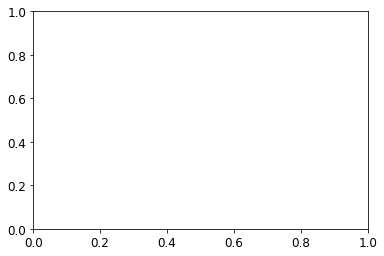

In [31]:
fig, ax = plt.subplots()
cax = None
def draw_frame(frame_num):
    global cax
    if cax != None:
        cax.remove()
    day = back[frame_num]
    value = go_thru[day]
    to_plot = geopandas.GeoDataFrame(value, geometry="geo")
    counties.plot(color="grey", figsize=(20,20), edgecolor= "white", ax=ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="15%", pad=0.1)
    to_plot.plot(column="percent deaths", cmap="OrRd",figsize=(30,30), legend=True, ax=ax, cax=cax)
    ax.set_title(day, fontsize = 20)
    cax.set_title("Deaths per 100 Cases", fontsize =10)
    print(frame_num)
    ax.set_axis_off()

In [32]:
anim = FuncAnimation(fig, draw_frame, frames=len(mod_it), interval=500)
html = anim.to_html5_video()
plt.close(fig)
new = HTML(html)
with open("two_weeks.html", "w") as f:
        f.write(str(html))
new

0
0
1
2
3
4
5
6
7
8
9
10


<Figure size 432x288 with 0 Axes>